In [ ]:
pip install optuna-integration[sklearn]

In [ ]:
# let op!!
#ER is 995 non-null entries  of Y in 2022
# er is 895 non-null entries of y in 2023
# For nested cross validation i only train the model that had perfrom the best in 2022. XGBoost

In [1]:
import pandas as pd
df_2023 = pd.read_csv("socio_demo_health.csv")

# Define the target variable of 2022
target_column = ['mhi5_class_2022']

# Columns that are inside blocks but MAY only be needed for error analysis
possible_error_analysis_columns = ['gender', 'Religion', 'Religious_Membership', 'political_interest','mhi5_std_score_2022', 'gender.1', 'Ethnic_Background', 'social_media_frequency' ]

# Full list of extra columns 2022
keep_columns = target_column + possible_error_analysis_columns  

# Step 1: Import the 2023 data with MHI-5 outcomes
mhi_df_2023 = pd.read_csv(r"C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\merged_df_2023_cleaned_with_traits_and_values_cleaned_final_cleaned.csv")

# Step 2: Extract only the necessary columns using the actual column names
mhi_subset_2023 = mhi_df_2023[['nomem_encr', 'class', 'standardized_score']]

# Step 3: Rename columns to match our expected naming convention for consistency
mhi_subset_2023 = mhi_subset_2023.rename(columns={
    'class': 'MHI5_class_2023',
    'standardized_score': 'MHI5_std_score_2023'
})

# Step 4: Merge with your original socio_demo_health dataframe
merged_df_2023 = df_2023.merge(mhi_subset_2023, on='nomem_encr', how='left')


In [3]:
print(merged_df_2023.isna().sum())

age                                        0
gender                                     0
sex                                        0
education                                  2
Employment_status                          0
Personal_Net_Income_Category               2
Ethnic_Background                         34
living_arrangement                         0
marital_status                             0
hours_on_social_media                      0
loneliness_score                           0
social_media_frequency                     9
SmallSnacks_Daily                          4
LargeSnacks_Weekly                         4
used_hallucinogens                         3
Self-Rated_Health                          0
Health_Hindrance_to_Daily_Functioning      2
Sleeping_Problems                          2
mhi5_class_2022                            1
gender.1                                   0
Religion                                 777
Religious_Membership                       0
political_

In [7]:
# Step 5: Prepare the 2023 features using the same transformations as 2022
# Keep only the same predictors that you used for X in 2022
X_2023 = merged_df_2023.drop(columns=keep_columns + ['MHI5_class_2023', 'MHI5_std_score_2023', 'nomem_encr'])
y_2023 = merged_df_2023['MHI5_class_2023']

X_2023.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    995 non-null    float64
 1   sex                                    995 non-null    float64
 2   education                              993 non-null    float64
 3   Employment_status                      995 non-null    int64  
 4   Personal_Net_Income_Category           993 non-null    float64
 5   living_arrangement                     995 non-null    float64
 6   marital_status                         995 non-null    float64
 7   hours_on_social_media                  995 non-null    float64
 8   loneliness_score                       995 non-null    int64  
 9   SmallSnacks_Daily                      991 non-null    float64
 10  LargeSnacks_Weekly                     991 non-null    float64
 11  used_h

In [9]:
y_2023.info()

<class 'pandas.core.series.Series'>
RangeIndex: 995 entries, 0 to 994
Series name: MHI5_class_2023
Non-Null Count  Dtype  
--------------  -----  
895 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [ ]:
# Reset indices
X_2023 = X_2023.reset_index(drop=True)
y_2023 = y_2023.reset_index(drop=True)

In [3]:
print(X_2023.shape)
print(y_2023.shape)

(995, 16)
(995,)


In [9]:
print(X_2023.isna().sum()) 
print('------------------')
print(y_2023.isna().sum())

age                                      0
sex                                      0
education                                2
Employment_status                        0
Personal_Net_Income_Category             2
living_arrangement                       0
marital_status                           0
hours_on_social_media                    0
loneliness_score                         0
SmallSnacks_Daily                        4
LargeSnacks_Weekly                       4
used_hallucinogens                       3
Self-Rated_Health                        0
Health_Hindrance_to_Daily_Functioning    2
Sleeping_Problems                        2
nomem_encr                               0
dtype: int64
------------------
100


In [15]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a mean filling strategy
# (If the columns are not numerical, strategy='most_frequent' must be used.)
imputer = SimpleImputer(strategy='mean')

# List of columns with missing values
columns_with_na = [
    'education', 'Personal_Net_Income_Category', 'SmallSnacks_Daily', 
    'LargeSnacks_Weekly', 'used_hallucinogens', 
    'Health_Hindrance_to_Daily_Functioning', 'Sleeping_Problems'
]

# Apply the imputer to the specified columns
X_2023[columns_with_na] = imputer.fit_transform(X_2023[columns_with_na])

# Check if the missing values are imputed
print(X_2023.isna().sum())

# Now handle NaNs in y_2023 (drop rows where target is missing)
valid_rows = y_2023.notna()

# Filter both X_2023 and y_2023 and reset their indices
X_2023 = X_2023.loc[valid_rows].reset_index(drop=True)
y_2023 = y_2023.loc[valid_rows].reset_index(drop=True)

print('---------')
print(y_2023.isna().sum())

age                                      0
sex                                      0
education                                0
Employment_status                        0
Personal_Net_Income_Category             0
living_arrangement                       0
marital_status                           0
hours_on_social_media                    0
loneliness_score                         0
SmallSnacks_Daily                        0
LargeSnacks_Weekly                       0
used_hallucinogens                       0
Self-Rated_Health                        0
Health_Hindrance_to_Daily_Functioning    0
Sleeping_Problems                        0
dtype: int64
---------
0


Split Train_test

In [23]:
from sklearn.model_selection import train_test_split

# Stratified train-test split (80% train, 20% test)
X_2023_train, X_2023_test, y_2023_train, y_2023_test = train_test_split(X_2023, y_2023, test_size=0.2, random_state=42, stratify=y_2023)

Nested Cross Validation

XGBoost

In [43]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# 1. Define your sampler map
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# 2. Custom pipeline class that resolves sampler strings
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# 3. Define the pipeline
pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),  # will be overridden
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])

# 4. Define Optuna-compatible search space
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': CategoricalDistribution([50, 100, 200, 400, 500]),
    'classifier__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'classifier__max_depth': CategoricalDistribution([2, 4, 6, 10, 15]),
    'classifier__min_child_weight': CategoricalDistribution([1, 3, 5]),
    'classifier__subsample': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__colsample_bytree': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__gamma': FloatDistribution(0.0, 1.0, step=0.1),
    'classifier__reg_alpha': FloatDistribution(0.001, 5.0, log=True),
    'classifier__reg_lambda': FloatDistribution(0.001, 5.0, log=True),
}

# 5. Setup OptunaSearchCV (inner 3-fold CV)
optuna_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,
    n_trials=50,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    study=optuna_study
)

# 6. Outer nested cross-validation (5-fold)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_2023_train,
    y=y_2023_train,
    cv=outer_cv,
    scoring='f1',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# 7. Print and save results
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))
print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")

# 8. Find the best model
best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print("Parameters of the best overall model:", best_model.best_params_)

# Save the best model for later prediction
joblib.dump(best_model, 'best_nested_cv_xgb_model.pkl')

# Optionally also save the full nested CV results (if you want)
#joblib.dump(nested_cv_results, 'nested_cv_results_xgb.pkl')


[I 2025-04-27 17:44:26,823] A new study created in memory with name: no-name-ed2a6fef-d123-44ce-8f57-e7baa81e9796
C:\Users\u1246538\AppData\Local\Temp\ipykernel_18028\4118579528.py:51: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV F1 scores: [0.50909091 0.35294118 0.45454545 0.60759494 0.64150943]
Mean F1 score: 0.5131363821556153
STD F1 score: 0.10441630670871813
Best parameters per fold:
Fold 1: {'sampler': 'smotetomek', 'classifier__n_estimators': 100, 'classifier__learning_rate': 0.033794805516188145, 'classifier__max_depth': 2, 'classifier__min_child_weight': 5, 'classifier__subsample': 1.0, 'classifier__colsample_bytree': 0.6, 'classifier__gamma': 0.4, 'classifier__reg_alpha': 0.010220696036038425, 'classifier__reg_lambda': 0.02345773500262351}
Fold 2: {'sampler': 'smotetomek', 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.017689085927436475, 'classifier__max_depth': 2, 'classifier__min_child_weight': 1, 'classifier__subsample': 0.6, 'classifier__colsample_bytree': 0.6, 'classifier__gamma': 0.4, 'classifier__reg_alpha': 0.026736441654175585, 'classifier__reg_lambda': 0.010092056413644782}
Fold 3: {'sampler': 'undersample', 'classifier__n_estimators': 50, 'classifier__learning_ra

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished


['best_nested_cv_xgb_model.pkl']

Find Best model(highest mean F1) and test on Hold_out Test Set

In [47]:
# 1. Check if all train columns exist in test data
missing_cols = set(X_2023_train.columns) - set(X_2023_test.columns)
extra_cols = set(X_2023_test.columns) - set(X_2023_train.columns)

print("Missing columns in test set:", missing_cols)
print("Extra columns in test set:", extra_cols)

# 2. Check if the columns are in the same order
same_order = list(X_2023_train.columns) == list(X_2023_test.columns)
print("Same column order:", same_order)


Missing columns in test set: set()
Extra columns in test set: set()
Same column order: True


Accuracy: 0.7765
F1 Score: 0.4286
ROC AUC: 0.7643
Average Precision (PR AUC): 0.5197

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       144
         1.0       0.43      0.43      0.43        35

    accuracy                           0.78       179
   macro avg       0.64      0.64      0.64       179
weighted avg       0.78      0.78      0.78       179



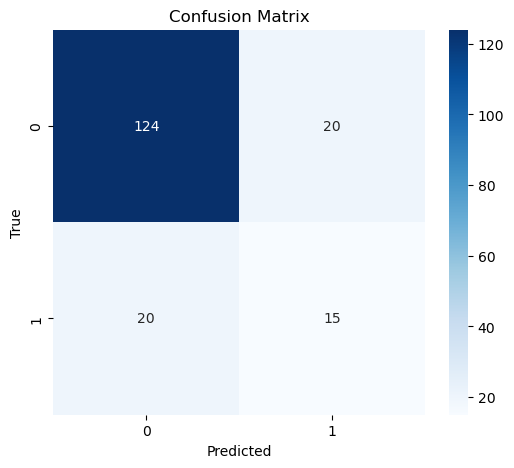

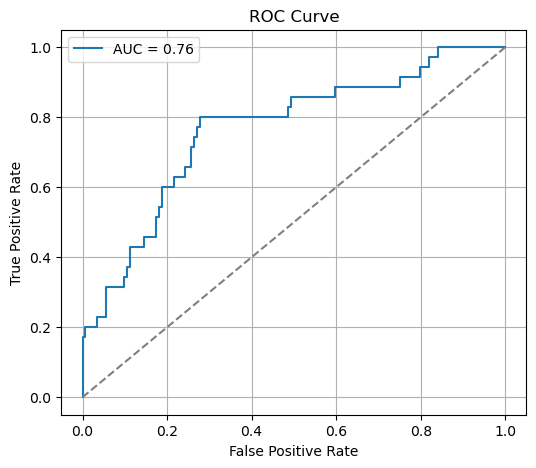

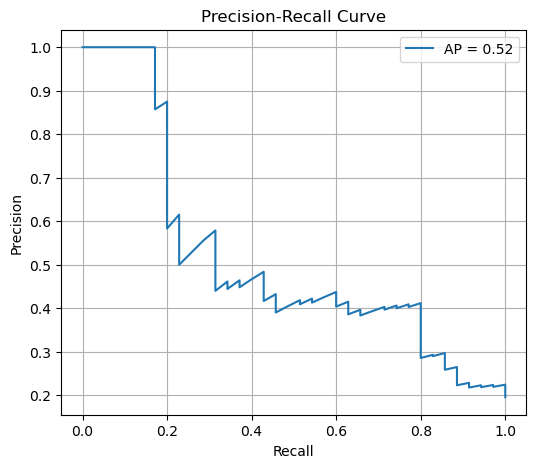

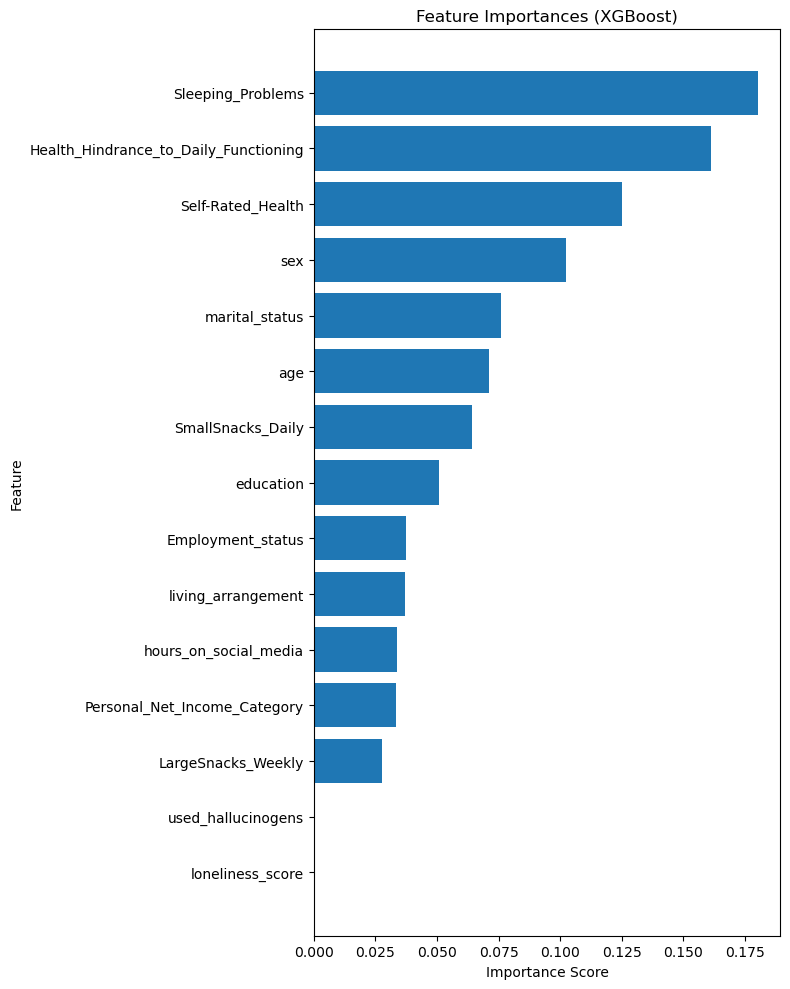

In [53]:
# First define evaluate_model function (your original code is already GOOD, no need to change it)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, roc_auc_score, classification_report,
    precision_recall_curve, average_precision_score
)

def evaluate_model(model, X_test, y_test, positive_label=1):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=positive_label)
    roc_auc = roc_auc_score(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision (PR AUC): {ap_score:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

    # Feature importance (only if model has 'classifier' step)
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
        feature_names = X_test.columns
        sorted_idx = np.argsort(importances)

        plt.figure(figsize=(8, 10))
        plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
        plt.yticks(np.arange(len(sorted_idx)), feature_names[sorted_idx])
        plt.title('Feature Importances (XGBoost)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("No feature importances available for this model.")


# 1. Load model
optuna_model = joblib.load('best_nested_cv_xgb_model.pkl')

# 2. Get the best pipeline from OptunaSearchCV
best_pipeline = optuna_model.best_estimator_

# 3. Now evaluate using the real trained pipeline
evaluate_model(best_pipeline, X_2023_test, y_2023_test)
